# Домашнее задание 1
## Harry Potter and the Action Prediction Challenge from Natural Language

**Выполнили**
Марк Фридман, Айжан Назирбекова, Дарья Арефьева, Фёдор Горбунов

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Часть 1. [2 балла] Эксплоративный анализ 
1. Найдите топ-1000 слов по частоте без учета стоп-слов.
2. Найдите топ-10 по частоте: имен, пар имя + фамилия, пар вида ''профессор'' + имя / фамилия. 

[бонус] Постройте тематическую модель по корпусу HPAC.

[бонус] Найдите еще что-то интересное в корпусе (что-то специфичное для фанфиков или фентези-тематики)

Для начала, поставим все необходимые библиотеки.

In [ ]:
! pip install -U spacy[cuda]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 15.5 MB/s 
  Created wheel for cupy: filename=cupy-11.3.0-cp37-cp37m-linux_x86_64.whl size=79586301 sha256=cd294f607a27e0cfd1dd32ce257f78bce0a0bf4bdd41eb12fdca32e8c68f1ebc
  Stored in directory: /root/.cache/pip/wheels/6d/e8/ff/0fbe95a330dc0b1b514aae33715318e57522cdb559da69a0eb
Successfully built cupy


In [3]:
! python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 15.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


__Скачиваем данные__

In [4]:
# Раскомментировать, если не скачаны
! wget https://www.dropbox.com/s/f93ouryjl4lo7vg/hpac_lower_tokenized.zip # предобработанные тексты
! unzip hpac_lower_tokenized.zip
# ! wget https://www.dropbox.com/s/23xet9kvbqna1qs/hpac_raw.zip # сырые тексты
# ! unzip hpac_raw.zip

! ls hpac_source > tokenized_file_names 
# ! ls hpac_raw > raw_file_names

with open("tokenized_file_names", "r") as f:
    tokenized_file_names = f.read().split()
# with open("raw_file_names", "r") as f:
#     raw_file_names = f.read().split()

Streaming output truncated to the last 5000 lines.
  inflating: hpac_source/4615642     
  inflating: hpac_source/7028138     
  inflating: hpac_source/7525139     
  inflating: hpac_source/5172600     
  inflating: hpac_source/3857376     
  inflating: hpac_source/5349382     
  inflating: hpac_source/4716141     
  inflating: hpac_source/2527816     
  inflating: hpac_source/9002674     
  inflating: hpac_source/12377877    
  inflating: hpac_source/4482433     
  inflating: hpac_source/12561875    
  inflating: hpac_source/3958842     
  inflating: hpac_source/2744273     
  inflating: hpac_source/7534883     
  inflating: hpac_source/9342729     
  inflating: hpac_source/9827191     
  inflating: hpac_source/4085248     
  inflating: hpac_source/2801654     
  inflating: hpac_source/6761621     
  inflating: hpac_source/9744246     
  inflating: hpac_source/2422618     
  inflating: hpac_source/11162505    
  inflating: hpac_source/10956839    
  inflating: hpac_source/3739578     

In [6]:
!pip3 install cleanco
!pip3 install fasttext
!pip3 install pyfasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 4.4 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3162062 sha256=bc42efa5644889267f20632519865b0bd1f50b065ec83d7e02ee6ad7673fd485
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 244 kB 14.8 MB/s 
  Using cached cysignals-1.11.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (871 kB)
  Created wheel for pyfasttext: filename=pyfasttext-0.4.6-cp37-cp37m-linux_x86_64.whl size=1460663 sha256=90f8e702504a5813285c5e1e8

__Подключаем библиотеки__

In [7]:
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import wordpunct_tokenize
from tqdm import tqdm, tqdm_notebook
import spacy
from spacy import displacy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import json

### 1.1
Нам понадобятся следующие функции

In [8]:
def fill_word_counter(text, counter, stopwords):
    tokenizer = RegexpTokenizer(r'\w+')
    lst_of_words = tokenizer.tokenize(text)
    for word in lst_of_words:
        if word in counter:
            counter[word] += 1
        else:
            counter[word] = 1

def remove_stop_words_from_counter(counter, stopwords):
    result = {}
    for word in counter:
        if word not in stopwords:
            result[word] = counter[word]
    return result

def top_k_frequent_words(counter, k, exclude_stop_words=False, stopwords=None):
    items = None
    if exclude_stop_words:
        counter_no_stop_words = remove_stop_words_from_counter(counter, stopwords)
        items = list(counter_no_stop_words.items())
    else:
        items = list(counter.items())
    items.sort(key=(lambda x : -x[1]))
    return items[:min(k, len(items))]
        

In [9]:
download('stopwords')
stopwords_ = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Найдём топ-1000 слов, специфичных именно для фанфиков. То есть удалим стоп-слова -- слова, которые часто встречаются вне зависимости от тематики

In [10]:
counter = {}  # конечно, можно было бы воспользоваться библиотекой Counter, но уже поздно
for filename in tqdm(tokenized_file_names):
    with open("hpac_source/" + filename) as f:
        fill_word_counter(f.read(), counter, stopwords_)

100%|██████████| 36225/36225 [03:50<00:00, 157.32it/s]


In [11]:
top1000words = top_k_frequent_words(counter, 1000, True, stopwords_)
top1000words

[('n', 4471018),
 ('harry', 4000496),
 ('said', 2262365),
 ('would', 1904645),
 ('hermione', 1831472),
 ('could', 1688265),
 ('back', 1400309),
 ('one', 1400091),
 ('draco', 1389977),
 ('like', 1275301),
 ('know', 1203946),
 ('eyes', 1033469),
 ('time', 1016961),
 ('ron', 906196),
 ('looked', 893446),
 ('get', 847653),
 ('asked', 826495),
 ('well', 802456),
 ('even', 770242),
 ('around', 767637),
 ('see', 744540),
 ('head', 737082),
 ('going', 718864),
 ('think', 716081),
 ('still', 694768),
 ('go', 667650),
 ('face', 657549),
 ('way', 656364),
 ('severus', 655654),
 ('room', 648484),
 ('hand', 639613),
 ('ginny', 639546),
 ('sirius', 630217),
 ('something', 623395),
 ('want', 613217),
 ('potter', 608400),
 ('thought', 608150),
 ('right', 603543),
 ('snape', 600470),
 ('away', 580725),
 ('much', 578715),
 ('two', 572219),
 ('look', 566544),
 ('never', 559461),
 ('really', 526366),
 ('knew', 524841),
 ('first', 523467),
 ('made', 513183),
 ('let', 513133),
 ('good', 510092),
 ('malfoy',

In [12]:
json.dump(top1000words, open("top1000words.json", 'w'))

In [13]:
top1000words = dict(json.load(open("top1000words.json")))

(Просто оставлю это здесь)

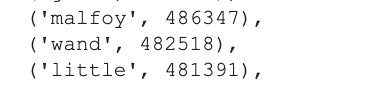

### 1.2
Чтобы определить, является ли слово именем, воспользуемся библиотекой spacy, в которой есть предобученная модель, дающая лейблы словам. По лейблу PERSON модно понять, имя ли это

In [16]:
import spacy
from spacy import displacy
from IPython.display import clear_output
spacy.require_gpu()
model = spacy.load("en_core_web_sm")

Чтобы не хранить все тексты в памяти, сделаем генератор текстов, который умеет доставать текущий текст и переходить к следующему

In [17]:
def split_n(n, text): # функция для того, чтобы разбивать фанфики на куски размера n
    return [text[i:i + n] for i in range(0, len(text), n)]

In [18]:
import nltk.data
import nltk
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
text_names = tokenized_file_names
def texts_generator():
    i = 0
    for filename in text_names:
        with open("hpac_source/" + filename) as f:
            sentences = sent_detector.tokenize(f.read().strip())    
            for sentence in sentences:
                yield sentence
        clear_output()
        print(i / len(text_names) * 100)
        i += 1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# раскомментировать для пересчёта файлов

# generator = texts_generator()
# name_entities = {}
# for doc in model.pipe(generator, disable=['tagger', 'parser'], batch_size=98):
#     for ent in doc.ents:
#         if ent.label_ == "PERSON":
#             if ent.text in name_entities:
#                 name_entities[ent.text] += 1
#             else:
#                 name_entities[ent.text] = 1

# json.dump(name_entities, open("name_entities.json", 'w'))



In [19]:
name_entities = dict(json.load(open( "name_entities.json")))

Просто прочитаем этот файл.

In [20]:
import pandas as pd

def to_df(d):
    df = pd.DataFrame(d.items(), columns=['name', 'freq'], index=None)
    return df.sort_values(by=['freq'], ascending=False).reset_index(drop=True)

names = to_df(name_entities)
names['num_words'] = names['name'].str.split(' ').apply(len)
names[names['num_words']==1].head(20)

,name,freq,num_words
0,harry,3005292,1
1,ron,452093,1
2,james,339566,1
3,-RRB-,187480,1
5,minerva,85160,1
6,peter,70927,1
7,charlie,64394,1
8,weasley,60157,1
9,george,56013,1
10,tom,50851,1


In [33]:
top10names = ['harry',
 'ron',
 'james',
 'minerva',
 'peter',
 'charlie',
 'weasley',
 'george',
 'tom',
 'daphne']

Выберем вручную топ-10 имён:



```
harry, ron, james, minerva, peter, charlie, weasley, george, tom, daphne	
```

Странно, что среди них нету Гермионы. Посмотрим, сколько раз её имя встретилось в тексте




In [53]:
name_entities['hermione']

2826

Да, действительно не часто
___
Теперь поищем пары имя-фамилия

In [21]:
names[names['num_words']==2].head(20)

,name,freq,num_words
4,harry potter,99240,2
11,harry nodded,40746,2
18,james potter,21344,2
24,hermione nodded,12628,2
25,ron looked,12326,2
35,ron weasley,10066,2
41,harry knew,8070,2
47,ronald weasley,6475,2
49,harry looked,6271,2
52,harry heard,6214,2


In [22]:
names['name'][-2:]

188222    ron mattered
188223    susan flamed
Name: name, dtype: object

Заметим, что модель часто воспринимает глаголы в прошедшем времени как фамилии. Попробуем отфильтровать имена, за которыми следует глагол, заканчивающийся на ed

In [23]:
names[(names['num_words']==2) & (names['name'].str[-2:] != 'ed')].head(20)

,name,freq,num_words
4,harry potter,99240,2
18,james potter,21344,2
35,ron weasley,10066,2
41,harry knew,8070,2
47,ronald weasley,6475,2
52,harry heard,6214,2
53,ron 's,6206,2
56,arthur weasley,5906,2
72,-RRB- ``,4774,2
83,ginny weasley,4302,2


In [34]:
top_10_names_surnames = ['harry potter',
 'james potter',
 'ron weasley',
 'ronald weasley',
 'arthur weasley',
 'ginny weasley',
 'neville longbottom',
 'george weasley',
 'molly weasley',
 'cho chang',
 'dean thomas',
 'peter pettigrew',
 'susan bones']

Итак, самые часто встречающиеся имя-фамилия по версии Spacy:


```
 'harry potter',
 'james potter',
 'ron weasley',
 'ronald weasley',
 'arthur weasley',
 'ginny weasley',
 'neville longbottom',
 'george weasley',
 'molly weasley',
 'cho chang',
 'dean thomas',
 'peter pettigrew',
 'susan bones'
```



Чтобы найти пары Профессор + имя/фамилия, будем искать слово "professor" и проверять, что следующее слово содержится в сете имён, выделенных Spacy как категория PERSON

In [25]:
import itertools

# names_set = set(itertools.chain.from_iterable(map(str.split, name_entities.keys())))
names_set = set(name_entities.keys())

In [26]:
# professors = {}
# for text in texts_generator():
#     words = text.split()
#     for i in range(len(words) - 1):
#         if words[i] == 'professor' and words[i + 1] in names_set:
#             prof_name = words[i] + ' ' + words[i + 1]
#             professors[prof_name] = professors.get(prof_name, 0) + 1
# json.dump(professors, open("professors.json", 'w'))

In [28]:
professors = dict(json.load(open("professors.json")))
prof = to_df(professors)
prof.head(15)

,name,freq
0,professor mcgonagall,381
1,professor vector,309
2,"professor ,",262
3,professor .,205
4,professor dumbledore,192
5,professor snape,192
6,professor lupin,115
7,professor flitwick,98
8,professor ?,71
9,professor slughorn,70


In [55]:
top_professor_10 = ['professor mcgonagall', 'professor vector', 'professor dumbledore', 
                    'professor snape', 'professor lupin', 'professor flitwick', 
                    'professor slughorn', 'professor sprout', 'professor malfoy', 
                    'professor trelawney', 'professor potter']

Хым, профессор Вектор встречается чаще, чем профессор Дамблдор. Вероятнее всего, это связано с тем, что Дамблдор в текстах описывался как просто Professor при обращении к нему, а при описании -- как Director.

### Построим график частоты

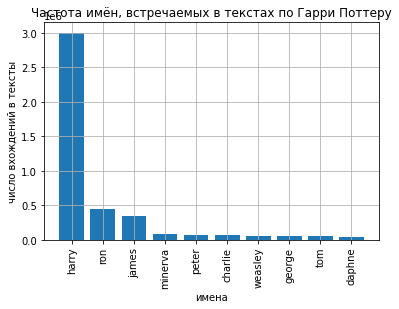

In [37]:
df = names[names['name'].isin(top10names)]
plt.xticks(rotation='vertical')
plt.bar(df['name'], df['freq'])
plt.xlabel("имена")
plt.ylabel("число вхождений в тексты")
plt.title("Частота имён, встречаемых в текстах по Гарри Поттеру")
plt.grid()
plt.show()

Теперь то же самое по фамилиям:

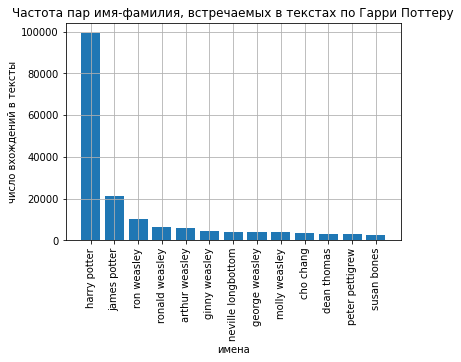

In [38]:
df = names[names['name'].isin(top_10_names_surnames)]
plt.xticks(rotation='vertical')
plt.bar(df['name'], df['freq'])
plt.xlabel("имена")
plt.ylabel("число вхождений в тексты")
plt.title("Частота пар имя-фамилия, встречаемых в текстах по Гарри Поттеру")
plt.grid()
plt.show()

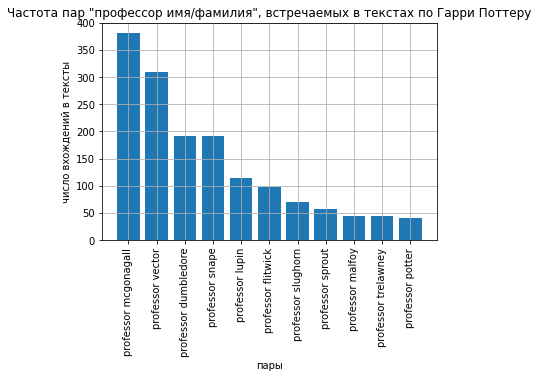

In [56]:
df = prof[prof['name'].isin(top_professor_10)]
plt.xticks(rotation='vertical')
plt.bar(df['name'], df['freq'])
plt.xlabel("пары")
plt.ylabel("число вхождений в тексты")
plt.title("Частота пар \"профессор имя/фамилия\", встречаемых в текстах по Гарри Поттеру")
plt.grid()
plt.show()

### Бонусы


Попробуем поискать что-то специфичное для фанфиков. Например, посмотрим кого с кем шипперят чаще всего


In [57]:
name_entities['ron potter']

4

In [58]:
name_entities['hermione potter']

13

In [59]:
name_entities['hermione malfoy']

19

In [60]:
name_entities['harry malfoy']

64

Ясно, понятно... 
Гарри пассив...

In [61]:
name_entities['ginny malfoy']

6

In [62]:
name_entities['lily snape']

KeyError: ignored

Я разочарован...

In [63]:
name_entities['minerva dumbledore']

KeyError: ignored



Что за эйджизм вообще...

Ещё интересно, что достаточно много вхождений "professor longbottom". Как мы знаем, в самой концовке Гарри Поттера сказано, что Невилл стал профессором. Видимо, есть много фанфиков, которые размышляют над продолжением саги

____
## Часть 2. [2 балла] Модели представления слов 
Обучите модель представления слов (word2vec, GloVe, fastText или любую другую) на материале корпуса HPAC.
1. Продемонстрируйте, как работает поиск синонимов, ассоциаций, лишних слов в обученной модели. 
2. Визуализируйте топ-1000 слов по частоте без учета стоп-слов (п. 1.1) с помощью TSNE или UMAP (https://umap-learn.readthedocs.io).

# Imports

In [ ]:
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
stopwords = stopwords.words('english')
nltk.download('punkt')

from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm

!pip3 install cleanco
from cleanco import cleanco
import string

!pip3 install fasttext
!pip3 install pyfasttext

import fasttext
from pyfasttext import FastText

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
  Created wheel for cleanco: filename=cleanco-1.3-cp36-none-any.whl size=5567 sha256=2ecede6dfbc6645559ecd88c655c240149aa0379928d33fa6a0c76864d5fbfa8
  Stored in directory: /root/.cache/pip/wheels/a4/71/3d/293ba67397d1bb749fa903617fbb1e39f98fe0cde301c47653
Successfully built cleanco
     |████████████████████████████████| 61kB 5.3MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2391283 sha256=2fdbe973871a1a39169ea14ef7f9cc52112db2760e3b4b91e028ada01d57790f
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext
     |████████████████████████████████| 245kB 6.5MB/s 
  Created wheel for pyfasttext: filename=pyfasttext-0.4.6-cp36-cp36m-linux_x86_64.whl si

In [ ]:
# ! wget https://www.dropbox.com/s/vmuji6t5k5k9quf/hpac_source.zip
# ! unzip hpac_source.zip

Соберём все тексты в один файлик

In [ ]:
! ls hpac_source > file_names
!touch all_texts

with open("file_names", "r") as f:
    file_names = f.read().split()
    
    
stopset = set(stopwords + list(string.punctuation) + list("n't") + list(range(10)))
def clean_text(text):
    text = [s for s in text if s not in stopset]
    return text

f1 = open('all_texts', "w+")
for path in tqdm(file_names):
    path = 'hpac_source/' + path
    with open(path, "r") as f:
        text = clean_text(f.read().split())
    f1.write(' '.join(text) + '\n')
f1.close()

100%|██████████| 36225/36225 [01:55<00:00, 313.31it/s]


## Train FastText


In [64]:
model = fasttext.train_unsupervised("all_text", model='skipgram', lr=0.05, dim=100, ws=5, epoch=50)
model.save_model("model_file.bin")
# !wget https://www.dropbox.com/s/wk115ou8pdzfiad/model_file.bin

In [ ]:
from gensim.models import FastText
model = FastText.load_fasttext_format('model_file.bin')

### Продемонстрируйте, как работает поиск синонимов, ассоциаций, лишних слов в обученной модели.

In [ ]:
print('Ближайшие слова к слову "potter"')
model.most_similar_cosmul('potter')

Ближайшие слова к слову "potter"


[('harry', 0.8806850910186768),
 ('potter-i', 0.877633810043335),
 ('malfoy', 0.873639702796936),
 ('ja-potter', 0.8735032677650452),
 ('you-potter', 0.8730138540267944),
 ('mister', 0.8693397045135498),
 ('potter-harry', 0.8692296743392944),
 ('potter-mcgonagall', 0.8655906319618225),
 ('ha-potter', 0.8653256297111511),
 ('potter-dumbledore', 0.8627368211746216)]

In [ ]:
print('Семантически близкие слова к слову "lips"')
model.most_similar('lips')

Семантически близкие слова к слову "lips"


[('chapped', 0.7774370908737183),
 ('mouth', 0.7684140205383301),
 ('kiss', 0.7307952642440796),
 ('sensuously', 0.7252484560012817),
 ('kiss-swollen', 0.7247886657714844),
 ('tongue', 0.7234187722206116),
 ('liplock', 0.706616222858429),
 ('almost-smile', 0.7048308849334717),
 ('cheek', 0.7021750211715698),
 ('almost-smiled', 0.6908326148986816)]

In [ ]:
print('Женская версия Поттера:')
model.most_similar(positive=['potter', 'woman'], negative=['man'])

Женская версия Поттера:


[('granger', 0.7785133123397827),
 ('she-potter', 0.7665696144104004),
 ('ginevra', 0.7623987197875977),
 ('you-potter', 0.7422727346420288),
 ('ginerva', 0.734724223613739),
 ('ja-potter', 0.7292128801345825),
 ('mu-granger', 0.7257972955703735),
 ('potter-i', 0.7193186283111572),
 ('lovegood-potter', 0.7173311114311218),
 ('granger-girl', 0.7170194387435913)]

In [ ]:
print('Мужская версия Грейнджер:')
model.most_similar(positive=['granger', 'man'], negative=['woman'])

Мужская версия Грейнджер:


[('potter', 0.7896385192871094),
 ('mister', 0.7309051156044006),
 ('miss', 0.6771351099014282),
 ('malfoy', 0.6692684888839722),
 ('harry', 0.6690064668655396),
 ('snape', 0.6532042622566223),
 ('yes', 0.6489603519439697),
 ('miss.granger', 0.6404379606246948),
 ('know-it-all-granger', 0.6345022320747375),
 ('may', 0.631962239742279)]

In [ ]:
print('Поищем синонимы к слову "cold"')
model.most_similar(positive=['cold', 'magician'], negative=['wizard'])

Поищем синонимы к слову "cold"


[('cool', 0.7039130926132202),
 ('cold-water', 0.6839228868484497),
 ('freezing', 0.6796563267707825),
 ('chilly', 0.6716446876525879),
 ('coldness', 0.668054461479187),
 ('frigid', 0.664495587348938),
 ('chill', 0.6623151302337646),
 ('freezing-cold', 0.6590023040771484),
 ('chilled', 0.6570422649383545),
 ('chiller', 0.651957631111145)]

In [ ]:
print(model.doesnt_match('harry hermione ron voldemort nose'.split()))
print('Лишнее "nose", т.к. не является именем героя')

nose
Лишнее "nose", т.к. не является именем героя


In [ ]:
print(model.doesnt_match('harry hermione ron voldemort'.split()))
print('Лишнее "voldemort", т.к. это единственный отрицательный герой')

voldemort
Лишнее "voldemort", т.к. это единственный отрицательный герой


In [ ]:
print(model.doesnt_match('harry hermione ron'.split()))
print('Лишнее "harry", т.к. это единственный главный герой, остальные второстепенные')

harry
Лишнее "harry", т.к. это единственный главный герой, остальные второстепенные


### Визуализируйте топ-1000 слов по частоте без учета стоп-слов (п. 1.1) с помощью TSNE или UMAP

In [ ]:
!wget https://www.dropbox.com/s/283peckve1a4nfm/top1000words.dct

--2019-10-09 09:57:29--  https://www.dropbox.com/s/283peckve1a4nfm/top1000words.dct
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.1, 2620:100:6026:1::a27d:4601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/283peckve1a4nfm/top1000words.dct [following]
--2019-10-09 09:57:36--  https://www.dropbox.com/s/raw/283peckve1a4nfm/top1000words.dct
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8c29a1aed1dca98f268e029794.dl.dropboxusercontent.com/cd/0/inline/AqHAAFjYSsNjoaGpSjgZux2BNVqqr5pOa_ZCDTR0Z0OCeL5gcuBwK2EZa6WvMzdtQeGWzSgXPrW_fc8pBTxKOlmr69DbbzPvjNB8JX30Y5wcKuZFmTW_g_0h8WaySS4qH8Y/file# [following]
--2019-10-09 09:57:37--  https://uc8c29a1aed1dca98f268e029794.dl.dropboxusercontent.com/cd/0/inline/AqHAAFjYSsNjoaGpSjgZux2BNVqqr5pOa_ZCDTR0Z0OCeL5gcuBwK2EZa6WvMzdtQeGWzSgXPrW_fc8pBTxKOlmr69DbbzPvjNB

In [ ]:
def read_dict_from_file(filename, sep):
    d = {}
    with open(filename, "r") as f:
        for line in f:
            key, value = line.strip().rsplit(sep, 1)
#             print(key, value)
            d[key] = int(value.strip())
    return d
top_words = list(read_dict_from_file('top1000words.dct', ';').keys())

In [ ]:
import numpy as np
X = np.zeros((len(top_words), 100))

for i, w in enumerate(top_words):
    X[i] = model.wv.get_vector(w)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
%matplotlib inline

# import seaborn as sns

X_embedded = TSNE(n_components=2).fit_transform(X)

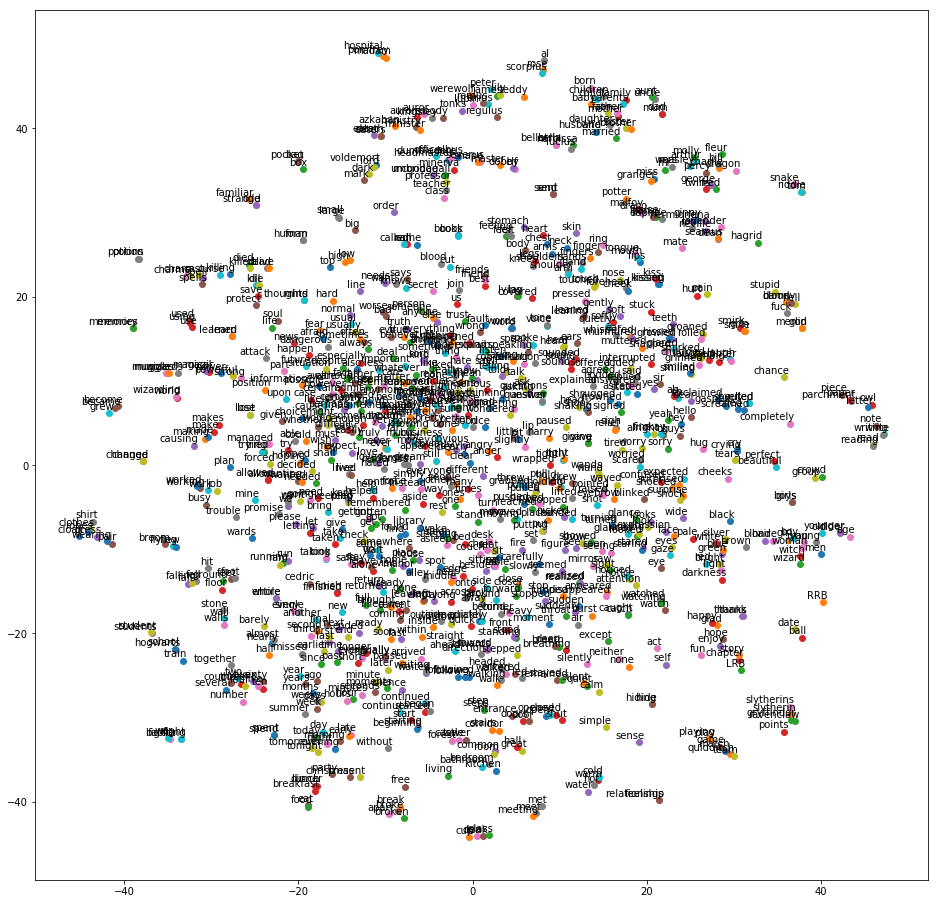

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(X, tokens):
    "Creates and TSNE model and plots it"
    labels = tokens
    
    x =  X[:, 0]
    y = X[:, 1]
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(X_embedded, top_words)

## Часть 3. [5 баллов] Классификация текстов
Задача классификации формулируется так: данный фрагмент фанфика описывают какую-то ситуацию, которая предшествует произнесению заклинания. Требуется по тексту предсказать, какое именно заклинание будет произнесено. Таким образом, заклинание - это фактически метка класса. Основная мера качества – macro $F_1$.
Обучите несколько классификаторов и сравните их между собой. Оцените качество классификаторов на частых и редких классах. Какие классы чаще всего оказываются перепутаны? Связаны ли ошибки со смыслом заклинаний?

Используйте фрагменты из множества train для обучения, из множества dev для отладки, из множества test – для тестирования и получения итоговых результатов. 

1. [1 балл] Используйте fastText в качестве baseline-классификатора.
2. [2 балла] Используйте сверточные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать $k$-max pooling. 
3. [2 балла] Попробуйте расширить обучающее множество за счет аугментации данных. Если вам понадобится словарь синонимов, можно использовать WordNet (ниже вы найдете примеры).

[бонус] Используйте результат max pooling'а как эмбеддинг входного текста. Визуализируйте эмбеддинги 500-1000 предложений из обучающего множества и изучите свойства получившегося пространства.

[бонус] Используйте ваш любимый классификатор и любые (честные) способы повышения качества классификации и получите macro $F_1$ больше 0.5.

### Используйте fastText в качестве baseline-классификатора.

In [ ]:
!wget  https://www.dropbox.com/s/3vdz0mouvex8abd/hpac_splits.zip
!unzip hpac_splits.zip

--2022-11-13 17:07:55--  https://www.dropbox.com/s/6pb265mweqdih57/hpac_splits.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/6pb265mweqdih57/hpac_splits.zip [following]
--2022-11-13 17:07:55--  https://www.dropbox.com/s/raw/6pb265mweqdih57/hpac_splits.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1cb1466bc5c82d75ac6b95f298.dl.dropboxusercontent.com/cd/0/inline/Bwp4lW-_UhSJIfpnpyopt_OtmySqnWA2slZyQZjujS-H_1HzFOd9_SdnkWxObfgnTapMkuIwg0EDzgw05Dk8gcjPsVdOaL_d8Hc0Hi6dH347KLKifT1KQPETBl1FH_2CvqNC8GciaD9E-GGnpHfVMnKGW52MxCopwYNfHoTbgeZoSg/file# [following]
--2022-11-13 17:07:56--  https://uc1cb1466bc5c82d75ac6b95f298.dl.dropboxusercontent.com/cd/0/inline/Bwp4lW-_UhSJIfpnpyopt_OtmySqnWA2slZyQZjujS-H_1HzFOd9_SdnkWxObfgnTapM

In [ ]:
import pandas as pd

train = pd.read_csv('hpac_corpus/hpac_training_128.tsv', delimiter='\t', names=['N', 'label', 'text'])
test = pd.read_csv('hpac_corpus/hpac_test_128.tsv', delimiter='\t', names=['N', 'label', 'text'])
dev =  pd.read_csv('hpac_corpus/hpac_dev_128.tsv', delimiter='\t', names=['N', 'label', 'text'])

In [ ]:
def data_preparing(data, name):
    with open(name, 'w') as f:
        for i in tqdm(range(len(data))):
            print(data.iloc[i][2] + ' __label__' + data.iloc[i][1] + '\n', file=f)
            
data_preparing(train, 'train')
data_preparing(test, 'test')
data_preparing(dev, 'dev')

100%|██████████| 7605/7605 [00:02<00:00, 2672.51it/s]


In [ ]:
model_sv = fasttext.train_supervised("train", epoch=150, lr=1., wordNgrams=3, verbose=2, minCount=1)

In [ ]:
model_sv.save_model("model_sv.bin")

In [ ]:
model_sv.test('test')

(7679, 0.34262273733559057, 0.34262273733559057)

In [ ]:
from sklearn.metrics import f1_score

test['predicted'] = test['text'].apply(lambda x: model_sv.predict(x)[0][0][9:])

print('F1-score on test:  %.7f' %(f1_score(test['predicted'], test['label'], average='macro')))

F1-score on test:  0.1682904


### Используйте сверточные сети в качестве более продвинутого классификатора.

In [ ]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Concatenate
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Reshape
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
# !pip3 install keras_metrics
import keras_metrics as km
plt.switch_backend('agg')
%matplotlib inline

In [ ]:
def clean_text(name):
#     name = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", name).strip() # добавление пробелов после символов, цифр
    name = ' '.join(cleanco(str(name)).clean_name()
                     .translate(str.maketrans('', '', string.punctuation))
                     .split()) # удаление знаков припенания и лишних пробелов
    tokens = nltk.word_tokenize(name) # переведем слова в массив слов
    tokens = [t.lower() for t in tokens] # слова в нижний регистр
    tokens = [t for t in tokens if t not in 
              stopset and len(t) > 1] # удаление стоп-слов
    
    return ' '.join(tokens)

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)
dev['clean_text'] = test['text'].apply(clean_text)

In [ ]:
macronum=sorted(set(train['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

In [ ]:
train['class'] = train['label'].apply(lambda x: macro_to_id[x])
test['class'] = test['label'].apply(lambda x: macro_to_id[x])
dev['class'] = dev['label'].apply(lambda x: macro_to_id[x])

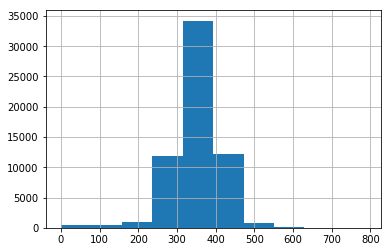

In [ ]:
train['clean_text'].apply(lambda x: len(x)).hist()
plt.show()

In [ ]:
df = pd.concat([train, test, dev], ignore_index=True)

In [ ]:
MAX_SEQUENCE_LENGTH = 500
MAX_NB_WORDS = 80000
EMBEDDING_DIM = 100
word_index = {}

def preprocess(df):
    texts = []
    labels = []


    for idx in df.index:
        text = BeautifulSoup(df['clean_text'][idx])
        texts.append(str(text.get_text().encode()))

    for idx in df['class']:
        labels.append(idx)
        
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    global word_index
    word_index = tokenizer.word_index
    index_word = {v: k for k, v in word_index.items()}
    print('Number of Unique Tokens',len(word_index))
    
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    labels = to_categorical(np.asarray(labels))
    
    print('Shape of Data Tensor:', data.shape)
    print('Shape of Label Tensor:', labels.shape)
    
    return data, labels

In [ ]:
x, y = preprocess(df)


x_train, y_train = x[:len(train)], y[:len(train)]
x_test, y_test = x[len(train):len(train) + len(test)], y[len(train):len(train) + len(test)]
x_val, y_val = x[len(train) + len(test):], y[len(train) + len(test):]

Number of Unique Tokens 77115
Shape of Data Tensor: (76264, 500)
Shape of Label Tensor: (76264, 85)


In [ ]:
len(word_index)

77115

In [ ]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
NB_WORDS = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((NB_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= NB_WORDS:
        continue
        # words not found in embedding index will be all-zeros.
    try:
        embedding_matrix[i] = model.wv.get_vector(word)
    except:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 7


In [ ]:
print(words_not_found)

['d', 'm', 'n', 't', 'y', "b'"]


### Архитектура модели

In [ ]:
num_filters=128
MAX_SEQUENCE_LENGTH = 500
MAX_NB_WORDS = 80000
EMBEDDING_DIM = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = len(macronum)
DROPOUT = 0.5

print("training CNN ...")


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = Embedding(NB_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], 
          input_length=MAX_SEQUENCE_LENGTH, trainable=True)(sequence_input)
embedded_sequences = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1), )(embedded_sequences)
pooled = []
for i, filter_size in enumerate(FILTER_SIZES):
    cnv = Conv2D(num_filters,kernel_size=[filter_size, EMBEDDING_DIM], 
                 activation='relu')(embedded_sequences)
    cnv = Reshape((-1, num_filters), )(cnv)
    pool = MaxPooling1D(MAX_SEQUENCE_LENGTH-filter_size+1)(cnv)
    pool = Flatten()(pool)
    pooled.append(pool)
concat = Concatenate()(pooled)
concat = Dropout(0.5)(concat)

dns = Dense(len(FILTER_SIZES) * num_filters, activation='relu')(concat)
print(type(dns))
preds = Dense(len(macronum), activation='softmax')(dns)










# model = Sequential()
# model.add(Embedding(NB_WORDS, EMBEDDING_DIM,
#           weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True))
# model.add(Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1), ))
# for i, filter_size in enumerate(FILTER_SIZES):
#     model.add(Conv2D(num_filters,kernel_size=[filter_size, EMBEDDING_DIM], activation='relu'))
#     model.add(Reshape((-1, num_filters), ))
# #     model.add(MaxPooling1D(pool_size=[MAX_SEQUENCE_LENGTH-filter_size+1, num_filters]))
#     model.add(MaxPooling1D(MAX_SEQUENCE_LENGTH-filter_size+1))
#     model.add(Flatten())
# # model.add(Conv1D(num_filters,4, activation='relu'))
# # model.add(MaxPooling1D(2))
# # model.add(Conv1D(num_filters,5, activation='relu'))
# # # model.add(MaxPooling1D(15))
# # model.add(GlobalMaxPooling1D())
# model.add(Dropout(0.5))
# model.add(Dense(num_filters, activation='relu'))
# model.add(Dense(OUTPUT_DIM, activation='softmax'))
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model.summary()

training CNN ...
<class 'tensorflow.python.framework.ops.Tensor'>
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 500, 100)     7711500     input_7[0][0]                    
__________________________________________________________________________________________________
reshape_66 (Reshape)            (None, 500, 100, 1)  0           embedding_52[0][0]               
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 498, 1, 128)  38528       reshape_66[0][0]                 
__________________________

In [ ]:
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_f1',verbose=1,save_best_only=True)

In [ ]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=128,callbacks=[cp])

Train on 60980 samples, validate on 7605 samples
Epoch 1/15
60980/60980 [==============================] - 79s 1ms/step - loss: 2.4696 - acc: 0.3684 - val_loss: 2.7210 - val_acc: 0.1854
Epoch 2/15
60980/60980 [==============================] - 79s 1ms/step - loss: 2.3538 - acc: 0.3927 - val_loss: 2.7633 - val_acc: 0.1819
Epoch 3/15
 1408/60980 [..............................] - ETA: 1:15 - loss: 2.2191 - acc: 0.4240

KeyboardInterrupt: ignored

In [ ]:
pred = np.argmax(model.predict(x_test), axis=1)

In [ ]:
y_test_cats = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import f1_score

print('F1-score on test:  %.7f' %(f1_score(pred, y_test_cats, average='macro')))

F1-score on test:  0.2622503


## Аугментация данных

Посмотрим как распределены классы

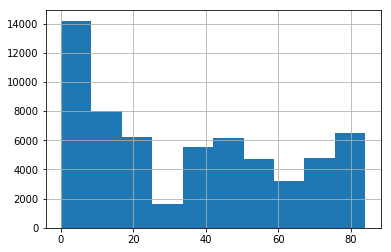

In [ ]:
train['class'].hist()
plt.show()

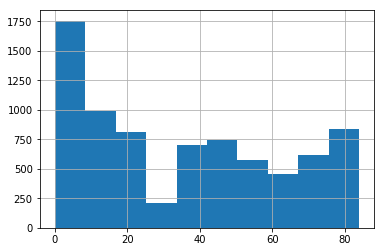

In [ ]:
test['class'].hist()
plt.show()

Видно, что классы несбалансированы. Но распределение на train и test примерно одинаковое. Аугментация здесь поможет, но не сильно.

## Часть 4. [1 балл] Итоги
Напишите краткое резюме проделанной работы. Читали ли вы сами Гарри Поттера или фанфики о нем и помогло ли вам знание предметной области в выполнении домашнего задания?

#### Краткое резюме проделанной работы
В этой работе мы познакомились с новыми инструментами и библиотеками, такими как

1.   **Spacy**: оказывается, в ней много интересных пайплайнов, в том числе полезный нам EntityRecognizer;
2.   **FastText**: в целом с идеей были знакомы, но саму библиотеку из gensim применяли впервые. У него достаточно широкий функционал, что открывает много вопросов о том, как его ещё можно использовать для более рабочих задач. Возможность складывать и вычитать векторы слов меня просто убила! Ну типа я знал это теоретически, но увидев на прктике "harry" - "man" + "woman" = "hermione" or "she-potter", я был сильно впечатлён.


Остальные библеотеки в принципе встречались раньше в рамках других курсов.

Хочется отметить, что датасет довольно большой и сложно было поэкспериментировать с нейросетевыми моделями и как-то улучшить их качество, так как всё обучается оооочень долго. Чтобы понять, улучит ли качество какое-то изменение в модели, надо прождать миллиард часов пока модель переобучится, что сильно демотивирует.

#### Читали ли вы сами Гарри Поттера или фанфики о нем и помогло ли вам знание предметной области в выполнении домашнего задания?

В нашей команде все читали Гарри Поттера, но мы бы не сказали, что это как-то помогло в выполнении заданий. Скорее, это просто делает задание более интересным для нас. 
P.S. С другой стороны, прочтение фанфика, где Гарри ловят слизеринцы после его превращения в Гойла, и в наказание устраивают моральное и физическое насилие категории 21+, помогло мне в поиске жертв шипперенга для бонусного задания.